## **Imports**

In [1]:
# setting path

import sys
sys.path.append('../scripts')
from dataset_loader import load_audio_files, load_transcripts, load_spectrograms_with_transcripts, load_spectrograms_with_transcripts_in_batches
from resize_and_augment import resize_audios_mono, augment_audio, equalize_transcript_dimension
from FeatureExtraction import FeatureExtraction
from transcript_encoder import fit_label_encoder, encode_transcripts, decode_predicted
from models import model_1
sys.path.append('../notebooks')


Bad key "text.kerning_factor" on line 4 in
C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import librosa   #for audio processing
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import mlflow
import mlflow.keras
import logging
len(os.listdir('../data/train/wav/'))

9

In [3]:
sample_rate = 8000

## **Load Audio Files**

In [4]:
audio_files, maximum_length = load_audio_files('../data/train/wav/', sample_rate, True)
logging.info('loaded audio files')

In [5]:
print("The longest audio is",maximum_length/sample_rate, 'seconds long')

The longest audio is 9.088 seconds long


## **Load Transcripts**

In [6]:
transcripts = load_transcripts("../data/train/trsTrain.txt")
logging.info('loaded transcripts')

In [7]:
maximum_length

72704

**Sample audio along with transcript**

In [8]:
demo_audio = list(audio_files.keys())[1]

In [9]:
ipd.Audio(audio_files[demo_audio], rate=sample_rate)

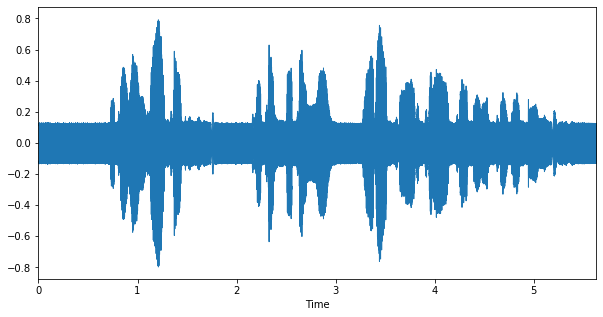

In [10]:
plt.figure(figsize=(10, 5))
librosa.display.waveplot(audio_files[demo_audio], sr=sample_rate)

In [11]:
transcripts[demo_audio]

' የ ጠመንጃ ተኩስ ተከፈተ ና አራት የኤርትራ ወታደሮች ተገደሉ'

## **Resize Audios For Mono Channel**

In [12]:
audio_files = resize_audios_mono(audio_files, maximum_length)
print(audio_files[demo_audio].shape)

(72704,)


**Sample Padded Audio**

In [13]:
ipd.Audio(audio_files[demo_audio], rate=sample_rate)

**Waveplot For Padded Audio**

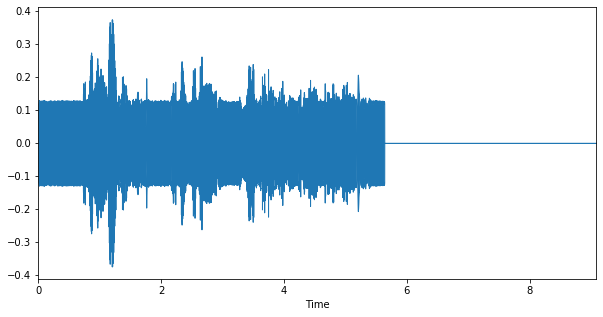

In [14]:
plt.figure(figsize=(10, 5))
librosa.display.waveplot(audio_files[demo_audio], sr= sample_rate)

## **Augment Audios**

In [15]:
audio_files = augment_audio(audio_files, sample_rate)

## **Extract Features**

In [16]:
feature_extractor = FeatureExtraction()

In [17]:
mfcc_features = feature_extractor.extract_features(audio_files, sample_rate)

**Plot MFCCs**

(20, 143)


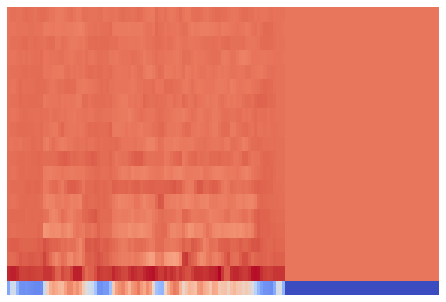

In [18]:
fig, ax = plt.subplots()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
mfccs = mfcc_features[demo_audio]
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')

**Plot Mel Spectrogram**

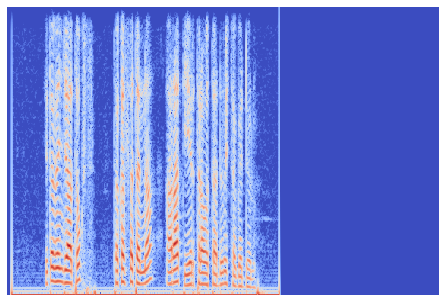

In [20]:
X = librosa.stft(audio_files[demo_audio], n_fft = 512)
Xdb = librosa.amplitude_to_db(abs(X))
fig, ax = plt.subplots()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')

**Save MFCC Spectrogram Images**

In [20]:
feature_extractor.save_mfcc_spectrograms(mfcc_features, sample_rate, '../data/train/mfcc_spectros/')

0

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

**Save Mel Spectrogram Images**

In [21]:
feature_extractor.save_mel_spectrograms(audio_files, sample_rate, '../data/train/mel_spectros/')

0

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

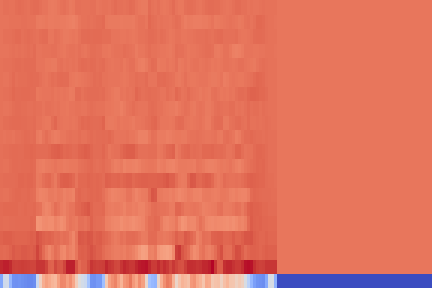

In [22]:
ipd.Image(filename=f'../data/train/mfcc_spectros/{demo_audio}.png')

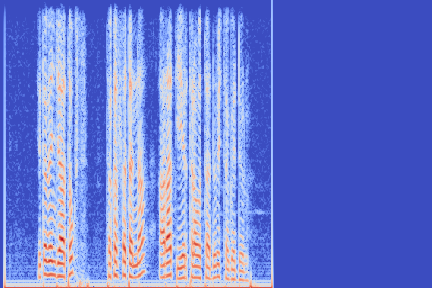

In [23]:
ipd.Image(filename=f'../data/train/mel_spectros/{demo_audio}.png')

**Fit Label Encoder with the Characters in the Transcripts**

In [21]:
char_encoder = fit_label_encoder(transcripts)

**Encode the Characters in the Transcripts**

In [22]:
transcripts_encoded = encode_transcripts(transcripts, char_encoder)

**Equalize transcript length by padding with spaces**

In [29]:
enc_aug_transcripts = equalize_transcript_dimension(transcripts_encoded, 50)

maximum number of characters in a transcript: 164


## **Prepare Training Set**

In [24]:
# X_train, y_train = load_spectrograms_with_transcripts(mfcc_features, 
#                                                       enc_aug_transcripts,
#                                                       '../data/train/mfcc_spectros/')
# X_train.shape, len(y_train)

In [25]:
# X_train, y_train = load_spectrograms_with_transcripts_in_batches(mfcc_features, 
#                                                       enc_aug_transcripts, 4, 0,
#                                                       '../data/train/mfcc_spectros/')
# X_train.shape, y_train.shape

## **Deep Learning Model**

In [30]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [31]:
model = model_1(char_encoder)
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 288, 432, 4) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 288, 432, 32) 1184        image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 144, 216, 32) 0           Conv1[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (None, 144, 6912)    0           pool1[0][0]                      
_______________________________________________________________________________________

## **Train Model**

This module loads data_batch_size spectrograms at a time and trains the model for the given number of epochs and with a given training_batch_size.

In [54]:
import math

data_batch_size = 9
training_batch_size = 9
number_of_epochs = 100

number_of_batches = math.ceil(len(mfcc_features)/data_batch_size)

for i in range(number_of_epochs):
    for j in range(number_of_batches):
        print(f'Epoch {i+1}: training batch {j}')
        X_train, y_train = load_spectrograms_with_transcripts_in_batches(mfcc_features, 
                                                              enc_aug_transcripts, data_batch_size, j,
                                                              '../data/train/mel_spectros/')
        #print(X_train.shape, y_train.shape)
        history = model.fit([X_train, y_train], batch_size = training_batch_size, epochs = 1)
with mlflow.start_run() as run:
    mlflow.log_metric("ctc_loss", history.history['loss'][-1])

Epoch 1: training batch 0
1/1 [==============================] - 0s 10ms/step - loss: 36.9289
Epoch 2: training batch 0
1/1 [==============================] - 0s 3ms/step - loss: 36.7740
Epoch 3: training batch 0
1/1 [==============================] - 0s 2ms/step - loss: 36.5163
Epoch 4: training batch 0
1/1 [==============================] - 0s 2ms/step - loss: 36.8586
Epoch 5: training batch 0
1/1 [==============================] - 0s 7ms/step - loss: 35.5075
Epoch 6: training batch 0
1/1 [==============================] - 0s 5ms/step - loss: 34.6450
Epoch 7: training batch 0
1/1 [==============================] - 0s 5ms/step - loss: 35.4582
Epoch 8: training batch 0
1/1 [==============================] - 0s 6ms/step - loss: 34.7569
Epoch 9: training batch 0
1/1 [==============================] - 0s 7ms/step - loss: 35.9084
Epoch 10: training batch 0
1/1 [==============================] - 0s 0s/step - loss: 35.8180
Epoch 11: training batch 0
1/1 [==============================] - 0s 

In [60]:
predicted = model.predict([X_train,y_train])
predicted_trans = decode_predicted(predicted, char_encoder)
real_trans = [''.join(char_encoder.inverse_transform(y)) for y in y_train]
print("pridicted:",predicted_trans[5])
print("actual:",real_trans[5])

pridicted: አ በ ለ ዶክተሩ ሁለመናነው የሚያመ ሎ ነገረው
actual:  አ በ በ ለ ዶክተሩ ሁለመና ዬን ነው የሚያመ ኝ ብሎ ነገረው           


In [53]:
len(set([np.argmax(pred) for pred in predicted[0]])), len(set(list("ጠመንጃ ተስከፈናአራት የኤርትራ ወታደሮችተ")))

(21, 21)

In [62]:
char_encoder.inverse_transform([144])

array(['የ'], dtype='<U1')